In [41]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# import febrisk
lib_path = os.path.join(os.path.abspath('.'), '..\\..')
sys.path.append(lib_path)

from febrisk.statistics import manhattan_distance, frobenius_norm
from febrisk.dist_fit import NormalFitter, TFitter
from febrisk.simulation import CopulaSimulator
from febrisk.risk import VaR, expected_shortfall
from febrisk.performance import cal_arith_return

warnings.filterwarnings('ignore')
sns.set_style("darkgrid")

# Problem 1
Use the data in problem1.csv. Fit a Normal Distribution and a Generalized T distribution to this data.
Calculate the VaR and ES for both fitted distributions.
Overlay the graphs the distribution PDFs, VaR, and ES values. What do you notice? Explain the
differences.

## Solution

Firstly, we fit a normal distribution and t distribution to this data using MLE. We will calculate the VaR and expected shortfall under these two distributions. Under the t distribution, more data are clustered around the center, therefore VaR under the t distribution is smaller than that under the normal distribution. However, as the t distribution has fatter tails, the expected shortfall under the t distribution is larger than that under the normal distribution.

In [42]:
p1_data = pd.read_csv("problem1.csv").values.T[0]

# fit
normal_fitter = NormalFitter()
normal_fitter.fit(x=p1_data)
norm_dist = normal_fitter.fitted_dist

t_fitter = TFitter()
t_fitter.fit(x=p1_data)
t_dist = t_fitter.fitted_dist

# simulate
nsample = 10000
norm_sim_data = norm_dist.rvs(nsample)
t_sim_data = t_dist.rvs(nsample)

var_norm = VaR(norm_sim_data, mean=0)
var_t = VaR(t_sim_data, mean=0)
print("VaR under Normal Distribution: ", var_norm)
print("VaR under T Distribution: ", var_t)

es_norm = expected_shortfall(norm_sim_data)
es_t = expected_shortfall(t_sim_data)
print("Expected Shortfall under Normal Distribution:", es_norm)
print("Expected Shortfall under T Distribution:", es_t)

VaR under Normal Distribution:  0.0828799504779208
VaR under T Distribution:  0.07811272807238093
Expected Shortfall under Normal Distribution: 0.10324607560290341
Expected Shortfall under T Distribution: 0.11233272909121524


Then we can plot the fitted distributions and the original data on one graph. We can see that the t distribution describes the characteristics of the data better, as it has more kurtosis than the normal distribution. The area filled with color are those has returns under VaR, and the expected return is annotated by a dash line.

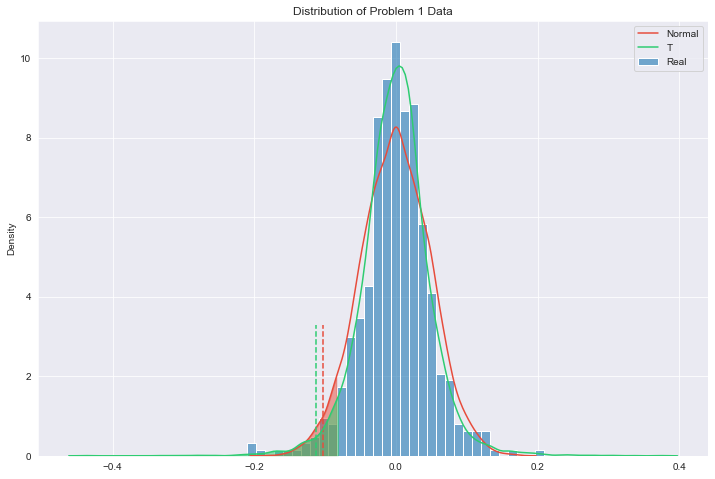

In [51]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.histplot(p1_data, stat='density', ax=ax, label='Real', alpha=0.6)

norm_c = "#e74c3c"
sns.kdeplot(norm_sim_data, ax=ax, label='Normal', color=norm_c)
ret, ret_density = ax.lines[0].get_data()
ax.fill_between(ret, ret_density, where=(ret<-var_norm), alpha=0.5, color=norm_c)
ax.axvline(-es_norm, 0, 0.3, color=norm_c, linestyle='--')

t_c = "#2ecc71"
sns.kdeplot(t_sim_data, ax=ax, label='T', color=t_c)
ret, ret_density = ax.lines[2].get_data()
ax.fill_between(ret, ret_density, where=(ret<-var_t), alpha=0.5, color=t_c)
ax.axvline(-es_t, 0, 0.3, color=t_c, linestyle='--')


ax.set_title("Distribution of Problem 1 Data")
ax.legend()

# Problem 2
In your main repository, create a Library for risk management. Create modules, classes, packages, etc
as you see fit. Include all the functionality we have discussed so far in class. Make sure it includes
1. Covariance estimation techniques.
2. Non PSD fixes for correlation matrices
3. Simulation Methods
4. VaR calculation methods (all discussed)
5. ES calculation
Create a test suite and show that each function performs as expected.

## Solution

Febrisk, the risk management library is created and used in this projects. The test suites are in the Duke_Fintech590/tests directory. 

# Problem 3
Use your repository from #2.
Using Portfolio.csv and DailyPrices.csv. Assume the expected return on all stocks is 0.
This file contains the stock holdings of 3 portfolios. You own each of these portfolios.
Fit a Generalized T model to each stock and calculate the VaR and ES of each portfolio as well as your
total VaR and ES. Compare the results from this to your VaR form Problem 3 from Week 4.

## Solution
We can use the gaussian copula to simulate the returns of each stock under t distributions, then calculate the Monte Carlo VaR and expected shortfall of the portfolios.

In [44]:
prices = pd.read_csv("DailyPrices.csv", parse_dates=["Date"], index_col=[0])
rets = cal_arith_return(prices)

expected_return_eq_0 = ({"type": "eq", "fun": lambda x: x[0]},)
fitters = [TFitter(expected_return_eq_0)
           for _ in range(rets.shape[1])]

cpl_simulator = CopulaSimulator()
cpl_simulator.fit(rets.values.T, fitters)
sim_rets = pd.DataFrame(columns=rets.columns, data=cpl_simulator.simulate(10000).T)

After the simulation, we can examine the wellness of each fittings by plotting the marginal distributions of simulated data and historical data. We can see hisotrical and simulated returns of each stock are generally under the same distributions.

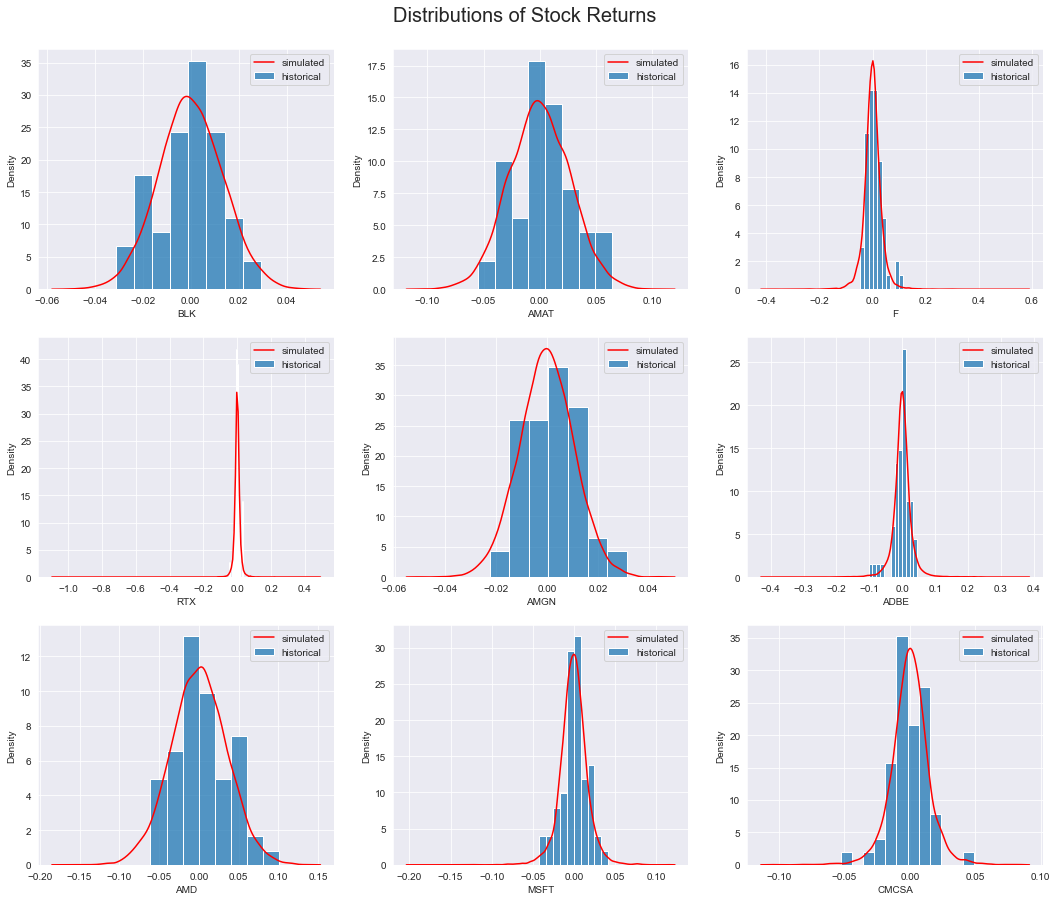

In [45]:
import random

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
stocks = random.sample(rets.columns.tolist(), 9)

fig.suptitle("Distributions of Stock Returns", fontsize=20, y=0.92)
for i, stock in enumerate(stocks):
    ax = axes[i//3][i%3]
    sns.histplot(rets[stock], ax=ax, stat='density', label='historical')
    sns.kdeplot(sim_rets[stock], ax=ax, color='r', label='simulated')
    ax.legend()

We may also calculate the covaraince of the simulated data and compare it to that of the historical data so as to further examine the wellness of the fittings. We can use mahattan distance and frobenius norm to evaluate the differences. As is shown in the following code block, the differences are small enough for a 101*101 matrix, and we can believe that the data are under the same distribution. 

In [46]:
cov_diff = np.cov(sim_rets.T) - np.cov(rets.T)
print("The Mahattan Distance between the covariance matrices is: ", manhattan_distance(cov_diff))
print("The Frobenius Norm between the covariance matrices is: ", frobenius_norm(cov_diff))

The Mahattan Distance between the covariance matrices is:  0.20118201264957652
The Frobenius Norm between the covariance matrices is:  0.006141801774772047


In the end we can calculate the VaR and expected shortfall to gain insights on the potential losses. There aren't too much difference from the results in Project 4, where historical VaR are used. 

Portfolio A
Monte Carlo VaR: 6255.82
Monte Carlo ES: 8187.05
Historical VaR: 5606.12
Historical ES: 7622.93

Portfolio B
Monte Carlo VaR: 4887.52
Monte Carlo ES: 6693.23
Historical VaR: 5613.08
Historical ES: 7231.08

Portfolio C
Monte Carlo VaR: 3927.94
Monte Carlo ES: 5428.76
Historical VaR: 3432.37
Historical ES: 4881.32

Portfolio D
Monte Carlo VaR: 14653.12
Monte Carlo ES: 19623.21
Historical VaR: 13790.83
Historical ES: 19735.33



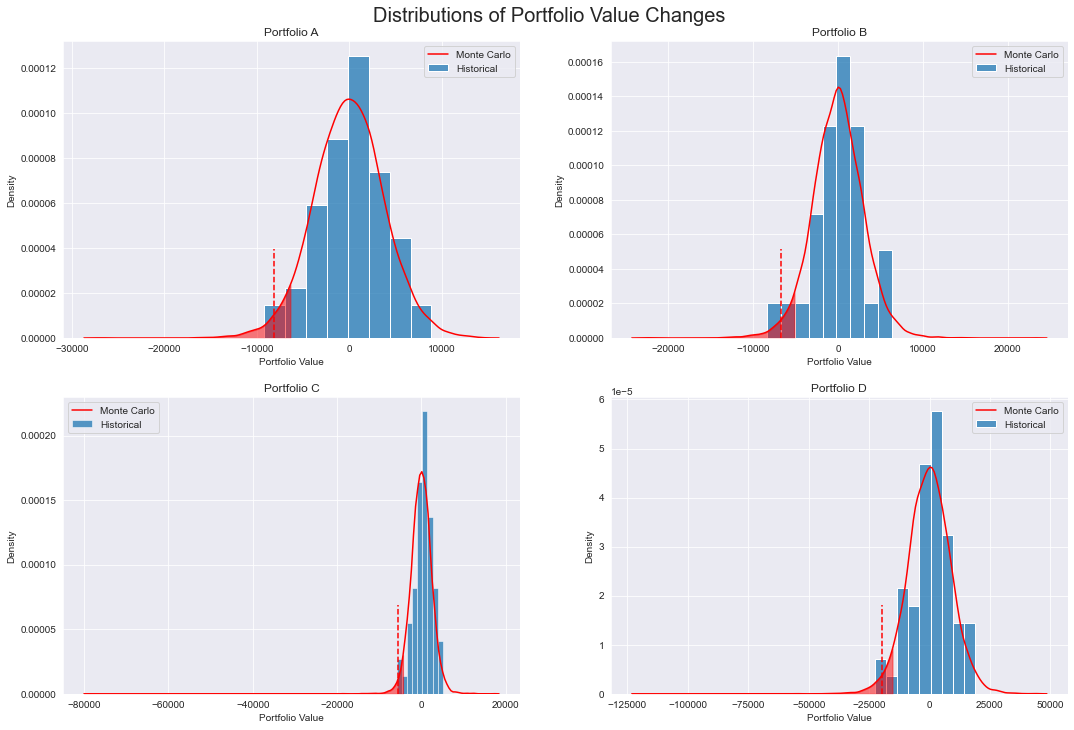

In [47]:
# load portfolio 
portfolios = pd.read_csv("Portfolio.csv")

# calculate total holdings on each asset, consider it as portfolio D
total_holdings = portfolios.groupby('Stock').sum('Holding')
total_holdings['Portfolio'] = 'D'
total_holdings = total_holdings.reset_index()
portfolios = pd.concat([portfolios, total_holdings], axis=0)

current_prices = pd.DataFrame({"Price":prices.iloc[-1]})

i = 0
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle("Distributions of Portfolio Value Changes", fontsize=20, y=0.92)
for pfl, pfl_df in portfolios.groupby('Portfolio'):
    # include current price of each asset
    portfolio = pfl_df.set_index('Stock')
    portfolio = portfolio.join(current_prices.loc[portfolio.index])

    # simulate changes in prices and values
    sim_price_chgs = sim_rets[portfolio.index] * portfolio['Price'].T
    sim_value_chgs = sim_price_chgs @ portfolio['Holding']

    # compare them to historical data 
    sim_price_chgs_hist = rets[portfolio.index] * portfolio['Price'].T
    sim_value_chgs_hist = sim_price_chgs_hist @ portfolio['Holding']
    
    # plot distributions
    ax = axes[i//2][i%2]
    sns.kdeplot(sim_value_chgs, ax=ax, label='Monte Carlo', color='r')
    sns.histplot(sim_value_chgs_hist, ax=ax, stat='density', label='Historical')
    ax.set_title(f"Portfolio {pfl}")
    ax.set_xlabel("Portfolio Value")
    ax.legend()

    # plot VaR and ES
    var = VaR(sim_value_chgs, 0)
    es = expected_shortfall(sim_value_chgs)
    ret, ret_density = ax.lines[0].get_data()
    ax.fill_between(ret, ret_density, where=(ret<-var), color='r', alpha=0.5)
    ax.axvline(-es, 0, 0.3, color='r', linestyle='--')

    # print results
    print(f"Portfolio {pfl}")
    print(f"Monte Carlo VaR: {var:.2f}")
    print(f"Monte Carlo ES: {es:.2f}")
    print(f"Historical VaR: {VaR(sim_value_chgs_hist, 0):.2f}")
    print(f"Historical ES: {expected_shortfall(sim_value_chgs_hist):.2f}")
    print()

    i += 1
